In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# https://stackoverflow.com/questions/37119071/scipy-rotate-and-zoom-an-image-without-changing-its-dimensions
import numpy as np
from scipy.ndimage import zoom


def clipped_zoom(img, zoom_factor, **kwargs):

    h, w = img.shape[:2]

    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # Zooming out
    if zoom_factor < 1:

        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        # Zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs)

    # Zooming in
    elif zoom_factor > 1:

        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)

        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # If zoom_factor == 1, just return the input array
    else:
        out = img
    return out

In [3]:
dimg = np.load('Images/101819_RS_depth.npy')

In [4]:
img = np.load('Images/101819_RS_color.npy')

In [5]:
img.shape

(480, 640, 3)

(168, 224, 3)


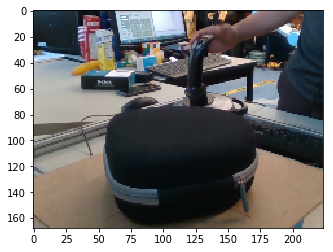

In [6]:
tmp = img[::2,::2]
j = 48
i= 0
print(tmp[24+j:24+168+j,32+i:32+224+i].shape)
plt.imshow(tmp[24+j:24+168+j,32+i:32+224+i])

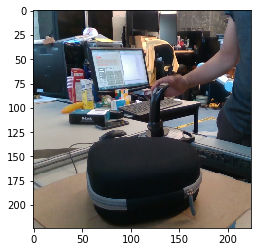

In [7]:
plt.imshow(tmp[-224:,32:32+224])

In [8]:
ls Data/cubes/2percent_removed/

negative_position_cube_compact.csv  prior_pos.npy
negative_position_cube.csv          Untitled.ipynb
positive_position_cube_compact.csv  voxel_centers.csv
positive_position_cube.csv          weighted_loss.npy
prior_compact.npy


In [9]:
pos = np.loadtxt('Data/cubes/2percent_removed/positive_position_cube_compact.csv', delimiter=',')
neg = np.loadtxt('Data/cubes/2percent_removed/negative_position_cube_compact.csv', delimiter=',')

In [10]:
uids = pos[:,0]

In [11]:
full_data = pd.read_csv('Data/raw_data/gripper_pose (rev 1 - closest center).tsv', sep='\t')

In [12]:
used_data = full_data[full_data.id.isin(uids)]

In [13]:
sorted(used_data.object.unique())

['120mm fan',
 'USB dock',
 'ZED box',
 'aluminum foot',
 'aluminum spacer',
 'arduino box',
 'ball',
 'baseball',
 'black flashlight',
 'blackboard eraser',
 'blakcboard eraser',
 'blue duplo arch',
 'blue jug',
 'blue lid',
 'blue spool',
 'blue tape',
 'carpet tape',
 'caster bag',
 'caster bag bad',
 'chips can',
 'clamp',
 'conical metal shape',
 'conical plastic shape',
 'conical wood shape',
 'creative box',
 'creative camera box',
 'dlink box',
 'duplo cart',
 'duplo eye',
 'empty spool',
 'eyebox',
 'flashlight',
 'foam brick',
 'foam corner',
 'glue stick',
 'go pro',
 'go pro remote',
 'gopro',
 'gopro remote',
 'grip tape',
 'headphones case',
 'inner fan tube',
 'kleenex box',
 'lab jack',
 'labjack',
 'large blue cup',
 'large orange cup',
 'large screw tray',
 'large yellow cup',
 'laser box',
 'laserbox',
 'measuring tape',
 'medium red box',
 'medium timmies cup',
 'mini soccer ball',
 'mustard bottle',
 'myo',
 'myo case',
 'orange box',
 'outer fan tube',
 'pipette b

In [14]:
used_data[used_data.object=='foam brick'].shape

(303, 18)

In [15]:
foam_brick_ids = used_data[used_data.object=='foam brick'].id

In [16]:
used_data[used_data.object=='blue jug'].shape

(276, 18)

In [17]:
blue_jug_ids = used_data[used_data.object=='blue jug'].id

In [18]:
303+276

579

In [19]:
1000-579

421

In [20]:
rand_ids = used_data[(used_data.object!='foam brick') & 
                     (used_data.object!='blue jug')].sample(n=421).id

In [21]:
val_uids = np.concatenate([foam_brick_ids.values, blue_jug_ids, rand_ids])

In [22]:
uids = pd.Series(uids)
tra_uids = uids[~uids.isin(val_uids)].values

In [23]:
imgs = np.zeros([tra_uids.shape[0], 224,224,3], dtype=np.float32)
for i,uid in enumerate(tra_uids.astype(int)):
    try:
        dimg = np.load('Images/{}_RS_depth.npy'.format(uid)) 
        dimg = dimg*0.00012498664727900177 # now in meters
        dimg[dimg>0.75] = 0 # Set stuff too far away to zero
        dimg = dimg/0.75
        
        dimg = np.roll(dimg, 25, axis=1)
        dimg = np.roll(dimg, -5, axis=0)
        dimg = clipped_zoom(dimg, 1.3)
        
        dimg = dimg[::2, ::2]
        dimg = dimg[-224:, 32:32+224]
        
        cimg = np.load('Images/{}_RS_color.npy'.format(uid))[::2,::2]
        cimg = cimg[-224:, 32:32+224]
        cimg = cimg.astype(np.float32)

        cimg[:,:,2] = dimg
        imgs[i] = cimg
    except:
        print('Stopping at iteration {} with uid {} because of an exception'.format(i,uid))
        break
max_d = imgs[:,:,:,2].max()
imgs[:,:,:,2] = imgs[:,:,:,2]/max_d * 255

/home/vreyesos/.local/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


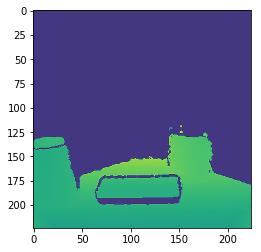

In [24]:
plt.imshow(dimg)

In [26]:
np.save('training_image_data_compact.npy', imgs)

In [27]:
np.save('training_uids_compact.npy', tra_uids)

In [28]:
imgs = np.zeros([val_uids.shape[0], 224,224,3], dtype=np.float32)
for i,uid in enumerate(val_uids.astype(int)):
    try:
        dimg = np.load('Images/{}_RS_depth.npy'.format(uid)) 
        dimg = dimg*0.00012498664727900177 # now in meters
        dimg[dimg>0.75] = 0 # Set stuff too far away to zero
        dimg = dimg/0.75
        
        dimg = np.roll(dimg, 25, axis=1)
        dimg = np.roll(dimg, -5, axis=0)
        dimg = clipped_zoom(dimg, 1.3)
        
        dimg = dimg[::2, ::2]
        dimg = dimg[-224:, 32:32+224]
        
        cimg = np.load('Images/{}_RS_color.npy'.format(uid))[::2,::2]
        cimg = cimg[-224:, 32:32+224]
        cimg = cimg.astype(np.float32)

        cimg[:,:,2] = dimg
        imgs[i] = cimg
    except:
        print('Stopping at iteration {} with uid {} because of an exception'.format(i,uid))
        break
imgs[:,:,:,2] = imgs[:,:,:,2]/max_d * 255

In [29]:
imgs.shape

(1000, 224, 224, 3)

In [30]:
np.save('validation_image_data_compact.npy', imgs)

In [31]:
np.save('validation_uids_compact.npy', val_uids)

In [32]:
tr_pos = pd.DataFrame(pos)
tr_pos = tr_pos[tr_pos.iloc[:,0].isin(tra_uids)].values

tr_neg = pd.DataFrame(neg)
tr_neg = tr_neg[tr_neg.iloc[:,0].isin(tra_uids)].values

In [33]:
val_pos = pd.DataFrame(pos)
val_pos = val_pos[val_pos.iloc[:,0].isin(val_uids)].values

val_neg = pd.DataFrame(neg)
val_neg = val_neg[val_neg.iloc[:,0].isin(val_uids)].values

In [34]:
np.save('training_positive_cubes_compact.npy', tr_pos)
np.save('training_negative_cubes_compact.npy', tr_neg)

In [35]:
np.save('validation_positive_cubes_compact.npy', val_pos)
np.save('validation_negative_cubes_compact.npy', val_neg)